In [2]:
# Importing python EDA Package

import pandas as pd

In [3]:
# Hide warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Sometimes, cached files might cause issues. We can try clearing the cache of our package manager

#!pip cache purge

In [5]:
# Load cleaned dataset for modelling which is in the form of csv

tweets = pd.read_csv("ProcessedData.csv")

In [6]:
tweets.columns

Index(['majority_target', 'tweet', 'followers_count', 'favourites',
       'friends_count', 'statuses_count', 'mentions', 'replies', 'cred',
       'clean_tweet', 'sentiment'],
      dtype='object')

In [7]:
# Knowing the size of our dataset

tweets.shape

(134198, 11)

In [8]:
# Previewing first 5 records from the head

tweets.head()

,majority_target,tweet,followers_count,favourites,friends_count,statuses_count,mentions,replies,cred,clean_tweet,sentiment
0,True,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,10.0,3619.0,16423.0,1.0,1.0,0.540794,biden blunders month update inflation delta mi...,Negative
1,True,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1.0,1621.0,37184.0,3.0,0.0,0.462177,people literally starving streets century capi...,Negative
2,True,THE SUPREME COURT is siding with super rich pr...,9.0,0.0,84.0,1184.0,0.0,5.0,0.096774,supreme court siding super rich property owner...,Negative
3,True,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,0.0,3619.0,16423.0,1.0,0.0,0.540794,biden blunders broken campaign promises inflat...,Negative
4,True,@OhComfy I agree. The confluence of events rig...,70.0,1.0,166.0,2194.0,1.0,0.0,0.296610,agree confluence events right unprecedented af...,Negative


In [10]:
#We will drop our features beside tweet for now, as we won't be able to compute the whole data due to memory allocation problem

modelling_dataset = tweets[['tweet','clean_tweet','sentiment']]

In [11]:
modelling_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   tweet        134198 non-null  object
 1   clean_tweet  134172 non-null  object
 2   sentiment    134198 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB


Label Encoding for target variable, 0 = Negative, 1 = Neutral, 2 = Positive

In [12]:
#Importing library for label encoding

from sklearn.preprocessing import LabelEncoder

In [13]:
# Label encode the target variable on both raw and clean dataset

label_encoder = LabelEncoder()
modelling_dataset['sentiment'] = label_encoder.fit_transform(modelling_dataset['sentiment'])

In [14]:
modelling_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   tweet        134198 non-null  object
 1   clean_tweet  134172 non-null  object
 2   sentiment    134198 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 2.6+ MB


In [15]:
modelling_dataset.tail()

,tweet,clean_tweet,sentiment
134193,Joe Biden's family owned African slaves....\n\...,bidens family owned african slaves bidens grea...,0
134194,"Joe Bidens great, great grandfather was a slav...",bidens great great grandfather slave owner fam...,2
134195,"@ChevyChaseToGo ""Joe Bidens great-grandfather ...",bidens greatgrandfather joseph biden slaveowne...,0
134196,@JoeBiden Facts are Bidens VP Kamala Harris Gr...,facts bidens kamala harris great great grandfa...,2
134197,@sunny Yes representation matters. Did you kno...,representation matters know bidens great great...,2


In [16]:
#Checking for target variable distribution across dataset

modelling_dataset['sentiment'].value_counts()

0    55364
1    40663
2    38171
Name: sentiment, dtype: int64

Since the number of data for negative sentiment is way higher, this can possibly create bias towards majority class which is negative sentiments. Thereby, we will create new dataset with less number of negative tweets for further processing with random sampling.

In [17]:
# Separate data by sentiment classes

positive_df = modelling_dataset[modelling_dataset['sentiment'] == 2]
neutral_df = modelling_dataset[modelling_dataset['sentiment'] == 1]
negative_df = modelling_dataset[modelling_dataset['sentiment'] == 0]

In [18]:
# Sample 39000 negative class tweets

sampled_negative_df = negative_df.sample(n=39000, random_state=1)

In [19]:
# Concatenate the sampled negative class with positive and neutral classes

balanced_df = pd.concat([sampled_negative_df, positive_df, neutral_df], ignore_index=True)

In [20]:
# Shuffle the rows of the balanced dataset and keep the feature attribute and target for modelling

modelling_dataset = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)
modelling_dataset.head()

,tweet,clean_tweet,sentiment
0,@RobertFoster4MS To be clearI am tired of hear...,cleari tired hearing votes national election m...,2
1,@oregonclematis And you look at what the progr...,look progressive wing democratic party pretty ...,2
2,@bal4_rednirus @Aprapl @GriffinJesdes You forg...,forget trump gave stimulus checks signature ch...,1
3,@meli_clem @killroy678 Forensic Audit Michigan...,forensic audit michigan election results,1
4,@mukai70975852 Thx\n\nIf we hold a stock &amp...,hold stock market closes years sleep night por...,2


In [21]:
modelling_dataset.shape

(117834, 3)

In [22]:
#Seperating dataframe into raw and clean, in order to later compare the result for choosing best feature extraction method

clean_data = modelling_dataset.drop(['tweet'],axis=1)
raw_data = modelling_dataset.drop(['clean_tweet'],axis=1)

In [23]:
# Importing Text Cleaning Package and cleaning some basic noise for dimension reduction which doesn't impact much on sentiment analysis beside short words and stop words.

!pip install neattext
import neattext.functions as nfx

In [24]:
raw_data['tweet'] = raw_data['tweet'].apply(nfx.remove_urls)
raw_data['tweet'] = raw_data['tweet'].apply(nfx.remove_multiple_spaces)
raw_data['tweet'] = raw_data['tweet'].apply(nfx.remove_numbers)
raw_data['tweet'] = raw_data['tweet'].apply(nfx.remove_puncts)
raw_data['tweet'] = raw_data['tweet'].apply(nfx.remove_punctuations)

In [25]:
# Checking for duplicates records

clean_data.duplicated().sum(),raw_data.duplicated().sum()

(9261, 575)

In [26]:
# Dropping duplicates records from clean dataset

clean_data = clean_data.drop_duplicates()
raw_data = raw_data.drop_duplicates()

In [27]:
# Checking for duplicates records

clean_data.duplicated().sum(),raw_data.duplicated().sum()

(0, 0)

In [28]:
#Checking for null data

clean_data.isna().sum(),raw_data.isna().sum()

(clean_tweet    3
 sentiment      0
 dtype: int64,
 tweet        0
 sentiment    0
 dtype: int64)

In [29]:
#Dropping null data from clean dataset

clean_data = clean_data.dropna()

In [30]:
#Checking for null data

clean_data.isna().sum()

clean_tweet    0
sentiment      0
dtype: int64

In [31]:
tweets.shape,raw_data.shape,clean_data.shape

((134198, 11), (117259, 2), (108570, 2))

In [32]:
#Veryfying data distribution in consideration of sentiment to avoid bias

clean_data.sentiment.value_counts(), raw_data.sentiment.value_counts()

(1    36964
 0    36156
 2    35450
 Name: sentiment, dtype: int64,
 1    40454
 0    38875
 2    37930
 Name: sentiment, dtype: int64)

Feature Extraction with different methods

In [33]:
# Assigning the sample tweets we will be working to extract the features from different methods

data = raw_data[1500:1510]
data

,tweet,sentiment
1500,DICK CHENEY advising Biden Id better not eat b...,0
1501,Sen @RogerMarshallMD: This is a time to believ...,1
1502,No one will be part of the New World Order unl...,1
1503,@Marti @RepLizCheney Biden is a Chaotic mess H...,0
1504,@realDonaldTrump @ChanelRion @OANN Biden won t...,2
1505,The US lost casualties in the yrs it was fig...,0
1506,@LizRNC In a scathing order a federal judge in...,0
1507,@TheLeadCNN This is bullshit And the emails th...,0
1508,@Docbailey @DCDraino This the work of spineles...,0
1509,@MarisaKabas Elizabeth Warren gave speeches to...,0


1. Bag of Words (BoW):

The Bag of Words model represents each document as a bag of individual words. It creates a vocabulary of unique words from the entire corpus and then converts each document into a fixed-length vector representing the frequency of each word in the vocabulary. This method is simple but can result in high-dimensional sparse vectors.

In [ ]:
#Importing count vectorizer toconvert a collection of text documents to a vector of term/token counts

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def cVectorizer(data,attr):

    #Create the CountVectorizer object

    vectorizer = CountVectorizer()

    #Learn the vocabulary and assign indices to tweets words

    bow_matrix = vectorizer.fit_transform(data[attr])

    # Convert the sparse matrix to a DataFrame

    feature_df = pd.DataFrame.sparse.from_spmatrix(bow_matrix, columns=vectorizer.get_feature_names_out())
    #altered_data = data.drop([attr,'sentiment'],axis=1)

    # Reset the indexes of the DataFrames
    #df1_reset = altered_data.reset_index(drop=True)
    #df2_reset = feature_df.reset_index(drop=True)

    # Merge the DataFrames based on their index
    #merged_df = pd.concat([df1_reset, df2_reset], axis=1)

    return(feature_df)

In [ ]:
#Result

cVectorizer(data,'tweet')

,abortion,act,advising,again,age,ago,agreed,an,and,anti,...,works,world,worship,year,years,you,your,youve,yr,yrs
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,0,1,0,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,2,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


2. Term Frequency-Inverse Document Frequency (TF-IDF):

TF-IDF is similar to BoW, but it takes into account the importance of words in a document relative to the entire corpus. It calculates a score for each word based on its frequency in the document (TF) and inversely proportional to its frequency across all documents (IDF). This helps to give more weight to words that are more informative for a particular document

In [ ]:
#Importing TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tVectorizer(data,attr):

    #Create the TfidfVectorizer object

    vectorizer = TfidfVectorizer()

    #Learn the vocabulary and assign indices to tweets words

    tfid_matrix = vectorizer.fit_transform(data[attr])

    # Convert the sparse matrix to a DataFrame

    feature_df = pd.DataFrame.sparse.from_spmatrix(tfid_matrix, columns=vectorizer.get_feature_names_out())
    #altered_data = data.drop([attr,'sentiment'],axis=1)

    # Reset the indexes of the DataFrames
    #df1_reset = altered_data.reset_index(drop=True)
    #df2_reset = feature_df.reset_index(drop=True)

    # Merge the DataFrames based on their index
    #merged_df = pd.concat([df1_reset, df2_reset], axis=1)


    return(feature_df)

In [ ]:
#Result

tVectorizer(data,'tweet')

,abortion,act,advising,again,age,ago,agreed,an,and,anti,...,works,world,worship,year,years,you,your,youve,yr,yrs
0,0.000000,0.000000,0.30719,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
1,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.294554,0.00000,0.00000
2,0.000000,0.153325,0.00000,0.00000,0.153325,0.000000,0.000000,0.130340,0.000000,0.000000,...,0.000000,0.153325,0.153325,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
3,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.110162,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.125916,0.000000,0.000000,0.000000,0.00000,0.00000
4,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.147317,0.000000,0.000000,0.000000,...,0.147317,0.000000,0.000000,0.00000,0.000000,0.294633,0.147317,0.000000,0.00000,0.00000
5,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.26102,0.000000,0.000000,0.000000,0.000000,0.13051,0.13051
6,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
7,0.000000,0.000000,0.00000,0.00000,0.000000,0.139451,0.000000,0.000000,0.122003,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
8,0.000000,0.000000,0.00000,0.18152,0.000000,0.154309,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.154309,0.000000,0.000000,0.000000,0.00000,0.00000
9,0.170232,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.144713,0.126607,0.170232,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000


3. Hashing Trick

The Hashing Trick is a memory-efficient technique that converts text into fixed-size feature vectors. It uses a hash function to map words to indices of a fixed-size array, and each word is hashed into one of the array positions. The resulting vectors can be used as features for machine learning models.

In [ ]:
#Importing library

from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
# Creating the HashingVectorizer object

hashing_vectorizer = HashingVectorizer(n_features=300)  # Set the desired size of the feature vectors

In [ ]:
# Converting documents to feature vectors using the hashing trick

document_matrix = hashing_vectorizer.transform(data['tweet'])

In [ ]:
# 'document_vectors' is a sparse matrix containing the hashed feature vectors

dense_document_array = document_matrix.toarray()

In [ ]:
print(dense_document_array)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.16903085  0.
   0.        ]
 [ 0.          0.          0.         ...  0.15075567  0.
   0.        ]]


Conclusion:
Since, we have enough memory resources with a good size dataset and care about the feature name with vocab storage, we don't need hashing trick as well. Thereby, we are left our with BoW and TF-IDF. To conclude one of the method, we will try to run a model on the outcome of both the method and generaize it. But as far as concerned, we may use TF-IDF as the term importance matters, providing higher weight to rare words and smoothing effects rather than BoW which gives th result in the form of binary number for each word.

Applying feature extraction method on RAW DATASET

In [ ]:
#Transforming the Dataset Using BoW and TF-IDF Vectorizer

bow_raw_data_X = cVectorizer(raw_data[0:4000],'tweet')
tfid_raw_data_X = tVectorizer(raw_data[0:4000],'tweet')

Applying feature extraction method on CLEAN DATASET

In [ ]:
#Transforming the Dataset Using BoW and TF-IDF Vectorizer

bow_clean_data_X = cVectorizer(clean_data[0:4000],'clean_tweet')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Separating the first 80% data for validation data, and 20% for testing data (For feature extraction method comparison,
# dataset selection, and hyperparameter tuning).
# We are directly addressing the data becuase it will take more time to split and save using train test split method

bow_X_raw_valid, bow_X_raw_test, bow_y_raw_valid, bow_y_raw_test = train_test_split(bow_raw_data_X, raw_data['sentiment'][:4000], test_size=0.2, random_state=1)
tfid_X_raw_valid, tfid_X_raw_test,tfid_y_raw_valid, tfid_y_raw_test = train_test_split(tfid_raw_data_X, raw_data['sentiment'][:4000], test_size=0.2, random_state=1)

Model Evaluation

We will create a function which includes Accuracy Score, Confusion Matrix, classification report, and ROC-AUC Curve. This function will be called to check the performance when our ML models will be trained.

In [ ]:
#Importing libraries for model evaluation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve

In [ ]:
#Defining function for evaluating model

def EvaluateModel(model,X_test,y_test):

    # Make predictions
    y_pred = model.predict(X_test)

    try:
        # Calculate accuracy
        print("Accuracy:", accuracy_score(y_test, y_pred))
    except ValueError:
        return None


    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred))

    # Create the heatmap for confusion matrix using Seaborn
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Actual Sentiment')
    plt.show()

    try:
        # Get classification report
        print("Classification Report:\n",classification_report(y_test, y_pred))
    except ValueError:
        return None

    try:
        # Calculate the probabilities for each class
        y_prob = model.predict_proba(X_test)

        # Compute ROC curve and AUC for each class
        plt.figure()
        for class_index in range(model.classes_.shape[0]):
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_index], pos_label=class_index)
            roc_auc = roc_auc_score(y_test == class_index, y_prob[:, class_index])

            plt.plot(fpr, tpr, lw=2, label='Class %d (AUC = %0.2f)' % (class_index, roc_auc))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves for All Classes')
        plt.legend(loc='lower right')
        plt.show()
    except AttributeError:
        return None

Dataset selection and Feature extraction method selecction using Logistic Regression


We will first use this model to know which feature extraction method is best and then we will re train the model with clean and raw tweet to see which one of the dataset gives better results.

Model 1 - Logistic Regression

Logistic regression is a statistical method that is used for building machine learning models where the dependent variable is dichotomous: i.e. binary. Logistic regression is used to describe data and the relationship between one dependent variable and one or more independent variables.

Despite its name, logistic regression can be used for multi-class classification problems by employing one-vs-rest (OvR) or one-vs-one (OvO) strategies. It is a simple and interpretable model that works well for linearly separable data.

In [ ]:
#Importing library for logistic regression

from sklearn.linear_model import LogisticRegression

In [ ]:
#Train the logistic regression model for data transated with bag of words

LRmodel1 = LogisticRegression()
LRmodel1.fit(bow_X_raw_valid, bow_y_raw_valid)

LogisticRegression()

Accuracy: 0.615


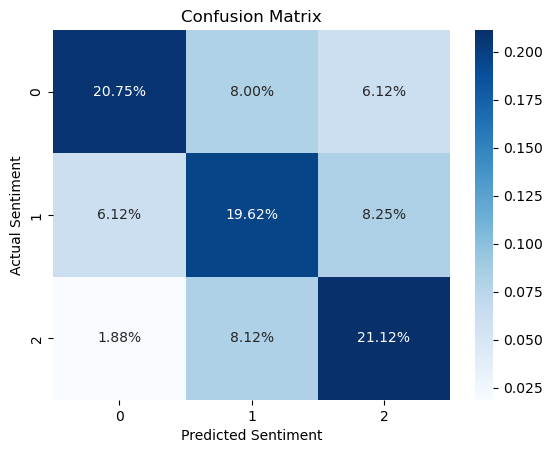

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.59      0.65       279
           1       0.55      0.58      0.56       272
           2       0.60      0.68      0.63       249

    accuracy                           0.61       800
   macro avg       0.62      0.62      0.62       800
weighted avg       0.62      0.61      0.62       800



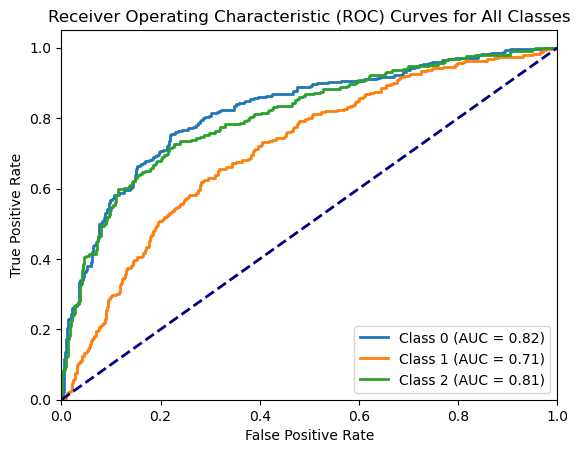

In [ ]:
EvaluateModel(LRmodel1,bow_X_raw_test,bow_y_raw_test)

In [ ]:
#Train the logistic regression model for data transated with TFID

LRmodel2 = LogisticRegression()
LRmodel2.fit(tfid_X_raw_valid, tfid_y_raw_valid)

LogisticRegression()

Accuracy: 0.5975


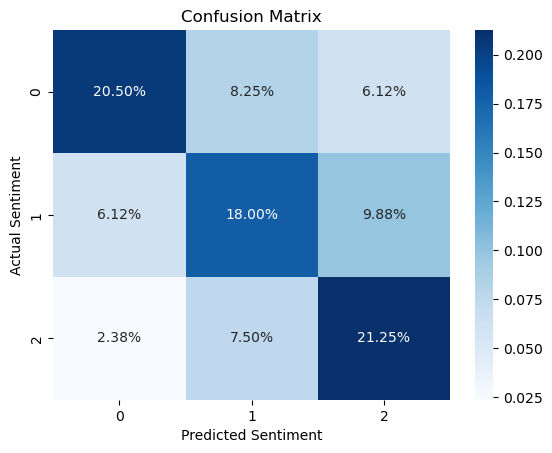

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.59      0.64       279
           1       0.53      0.53      0.53       272
           2       0.57      0.68      0.62       249

    accuracy                           0.60       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.61      0.60      0.60       800



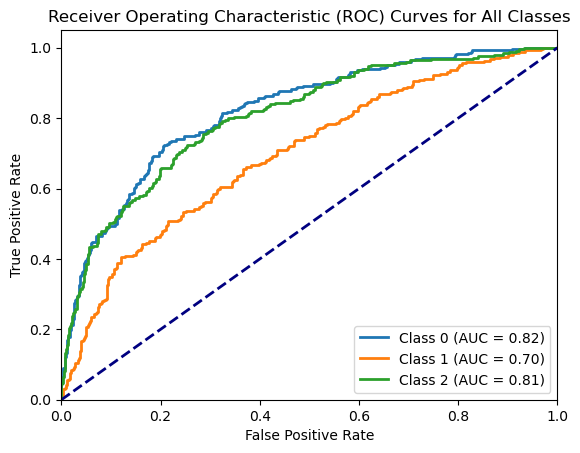

In [ ]:
EvaluateModel(LRmodel2,tfid_X_raw_test,tfid_y_raw_test)

Since, model 1 gave accuracy of 61.5% and model 2 gave 59.75%, we choose BoW for feature extarction.

> Indented block



Now we will evaluate our model on clean data, therby we can figure out which dataset to use for final model buidling.


In [ ]:
bow_X_clean_valid, bow_X_clean_test, bow_y_clean_valid, bow_y_clean_test = train_test_split(bow_clean_data_X, clean_data['sentiment'][:4000], test_size=0.2, random_state=1)

In [ ]:
#Train the logistic regression model for data transated with TFID

LRmodel3 = LogisticRegression()
LRmodel2.fit(bow_X_clean_valid, bow_y_clean_valid)

LogisticRegression()

Accuracy: 0.58625


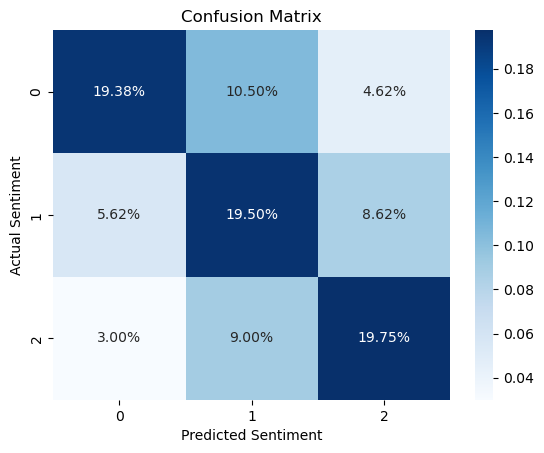

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.56      0.62       276
           1       0.50      0.58      0.54       270
           2       0.60      0.62      0.61       254

    accuracy                           0.59       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.59      0.59       800



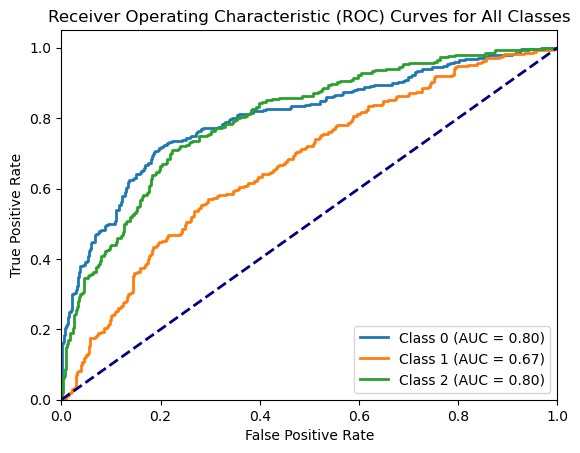

In [ ]:
EvaluateModel(LRmodel2,bow_X_clean_test,bow_y_clean_test)

Conclusion on dataset to use: Since the accuracy of model 1 is 61.5% and model is 58.6%, we will use the raw miner noise cleaned dataset wit BoW feature extarction method.

Since, we got our inital accuracy, we will set the base accuracy standard of 61.5% for our different machine learning model comparison

Modelling with all available Data

In [ ]:
#Transforming the Dataset Using BoW

bow_raw_data = cVectorizer(raw_data,'tweet')

We will set 80% of our data for training and remaing 20% for testing. For hyper parameter tuning, we will use the validation data used before.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_raw_data, raw_data['sentiment'], test_size=0.2, random_state=1)

Model 1 - Logistic Regression

In [ ]:
#Importing library for tuning hyperparameter

from sklearn.model_selection import GridSearchCV

In [ ]:
#Perform hyperparameter tuning with validation data

parameters = {'C': [90,100,110]}
logistic = LogisticRegression()
grid_search = GridSearchCV(logistic, parameters, cv=5)
grid_search.fit(bow_X_raw_valid, bow_y_raw_valid)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [90, 100, 110]})

In [ ]:
#Get the best hyperparameter 'C'

best_params = grid_search.best_params_
print("Best params value:", best_params)

Best params value: {'C': 100}


In [ ]:
#Train the logistic regression model using the best hyperparameter

LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)

LogisticRegression()

Accuracy: 0.7473136619478082


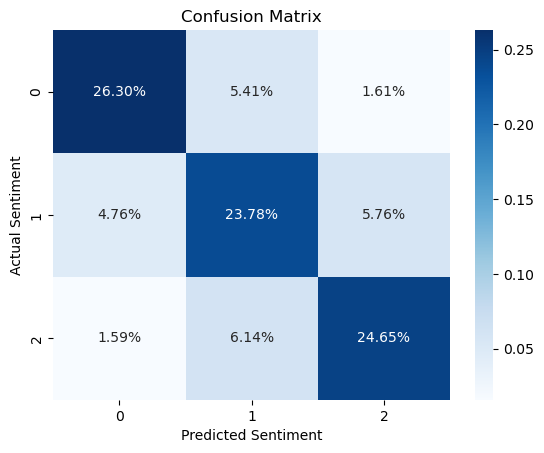

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      7814
           1       0.67      0.69      0.68      8045
           2       0.77      0.76      0.77      7593

    accuracy                           0.75     23452
   macro avg       0.75      0.75      0.75     23452
weighted avg       0.75      0.75      0.75     23452



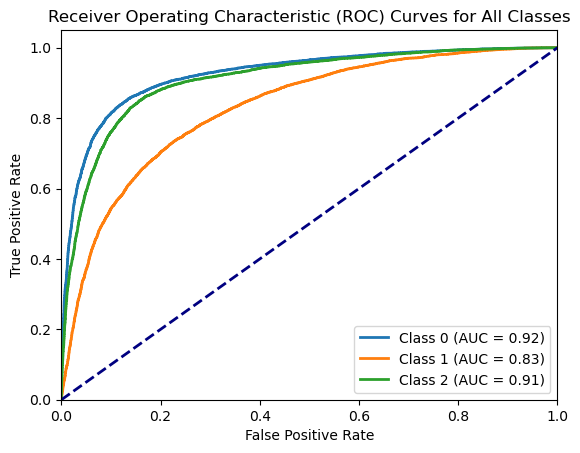

In [ ]:
EvaluateModel(LRmodel,X_test,y_test)

Model 2 - Multinomial Naive Bayes

Multinomial Naive Bayes is a variant of the Naive Bayes algorithm that is commonly used for multi-class classification tasks, particularly when dealing with text or discrete data. It's suitable for situations where features represent counts or frequencies of events.

In [ ]:
#Importing Multinomial Naive Bayes model

from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Perform hyperparameter tuning with validation data

parameters = {'alpha': [0.1,0.5,1.0]}
mnb = MultinomialNB()
grid_search = GridSearchCV(mnb, parameters, cv=5)
grid_search.fit(bow_X_raw_valid, bow_y_raw_valid)  # Use validation data for hyperparameter tuning

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]})

In [ ]:
# Get the best hyperparameter 'alpha'

best_alpha = grid_search.best_params_['alpha']
print("Best 'alpha' value:", best_alpha)

Best 'alpha' value: 1.0


In [ ]:
# Train the Multinomial Naive Bayes model using the best hyperparameter 'alpha'

MNBmodel = MultinomialNB(alpha=best_alpha)
MNBmodel.fit(X_train, y_train)

MultinomialNB()

Accuracy: 0.6417789527545625


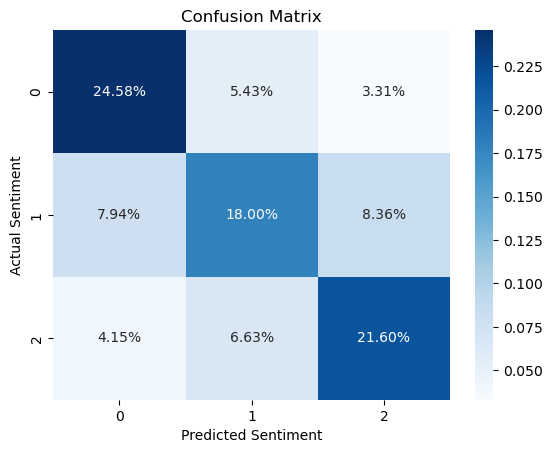

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70      7814
           1       0.60      0.52      0.56      8045
           2       0.65      0.67      0.66      7593

    accuracy                           0.64     23452
   macro avg       0.64      0.64      0.64     23452
weighted avg       0.64      0.64      0.64     23452



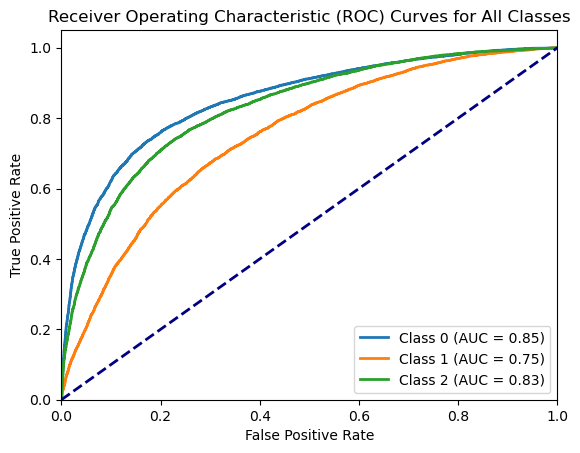

In [ ]:
# Evaluating the model

EvaluateModel(MNBmodel,X_test,y_test)

Model 3 - Linear SVC

LinearSVC is a linear Support Vector Classification (SVC) algorithm in scikit-learn. It is a variant of the SVM algorithm, specifically designed for linearly separable datasets.

In [ ]:
#Importing SVC library

from sklearn.svm import LinearSVC

In [ ]:
#Perform hyperparameter tuning with validation data

parameters = {'C': [0.01,0.05,0.001]}
svc = LinearSVC()
grid_search = GridSearchCV(svc, parameters, cv=5)
grid_search.fit(bow_X_raw_valid, bow_y_raw_valid)

GridSearchCV(cv=5, estimator=LinearSVC(), param_grid={'C': [0.01, 0.05, 0.001]})

In [ ]:
# Get the best hyperparameter 'C'

best_params = grid_search.best_params_
print(best_params)

{'C': 0.05}


In [ ]:
# Train the LinearSVC model using the best hyperparameter

SVCmodel = LinearSVC(**best_params)
SVCmodel.fit(X_train, y_train)

LinearSVC(C=0.05)

Accuracy: 0.7431775541531639


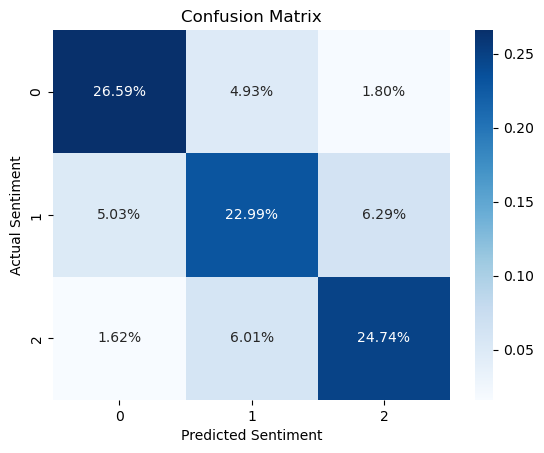

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      7814
           1       0.68      0.67      0.67      8045
           2       0.75      0.76      0.76      7593

    accuracy                           0.74     23452
   macro avg       0.74      0.74      0.74     23452
weighted avg       0.74      0.74      0.74     23452



In [ ]:
#Evaluate model

EvaluateModel(SVCmodel,X_test,y_test)

Model 4 - Random Forest

Random Forest is an ensemble learning method that combines multiple decision trees to make more accurate predictions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Perform hyperparameter tuning with validation data

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}
r_model = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(r_model, param_grid, cv=5,n_jobs=-1)
grid_search.fit(bow_X_raw_valid, bow_y_raw_valid)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 150]})

In [ ]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print(best_params,best_rf)

{'max_depth': 30, 'n_estimators': 150} RandomForestClassifier(max_depth=30, n_estimators=150, random_state=1)


In [ ]:
# Train the LinearSVC model using the best hyperparameter

RFmodel = RandomForestClassifier(**best_params)
RFmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=150)

Accuracy: 0.6205014497697424


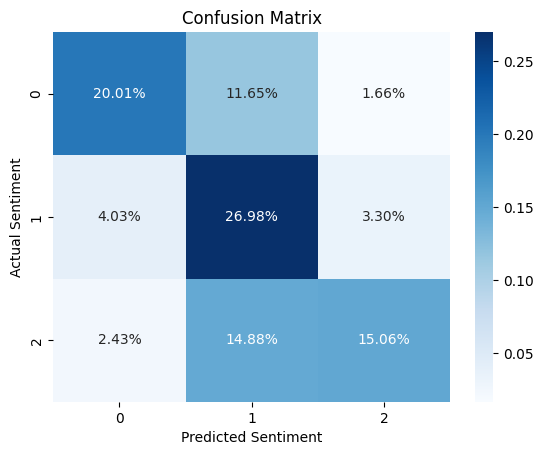

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.60      0.67      7814
           1       0.50      0.79      0.61      8045
           2       0.75      0.47      0.57      7593

    accuracy                           0.62     23452
   macro avg       0.67      0.62      0.62     23452
weighted avg       0.67      0.62      0.62     23452



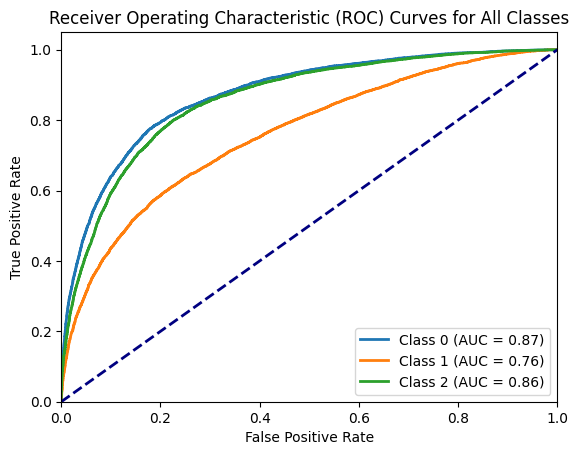

In [ ]:
#Evaluate model

EvaluateModel(RFmodel,X_test,y_test)

Model 5 - KNN
K-Nearest Neighbors (KNN) is a simple and intuitive machine learning algorithm used for both classification and regression tasks. It's a type of instance-based learning where the algorithm doesn't explicitly learn a model. Instead, it makes predictions based on the similarity of input data points to other data points in the training dataset.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_neighbors': [2,3, 5],
    'weights': ['distance'],
    'p': [1]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)  # 5-fold cross-validation

# Perform the grid search on the training data
grid_search.fit(bow_X_raw_valid, bow_y_raw_valid)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5], 'p': [1],
                         'weights': ['distance']})

In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


In [ ]:
#Training model with the best hyper parameter

KNNmodel = KNeighborsClassifier(**best_params)
KNNmodel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Accuracy: 0.5447296605833192


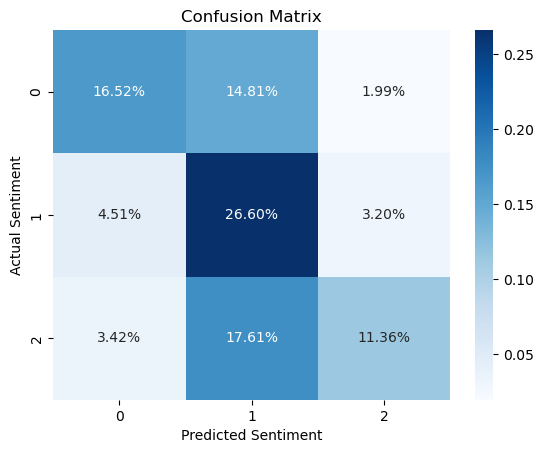

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.50      0.57      7814
           1       0.45      0.78      0.57      8045
           2       0.69      0.35      0.46      7593

    accuracy                           0.54     23452
   macro avg       0.60      0.54      0.54     23452
weighted avg       0.60      0.54      0.54     23452



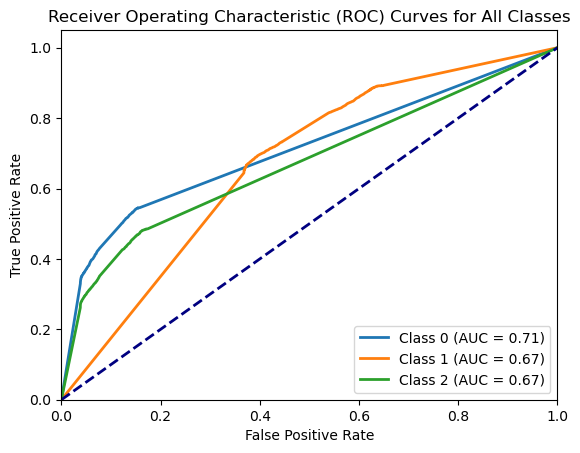

In [ ]:
#Evaluate model

EvaluateModel(KNNmodel,X_test,y_test)

Plotting Optimal features from our modelling features

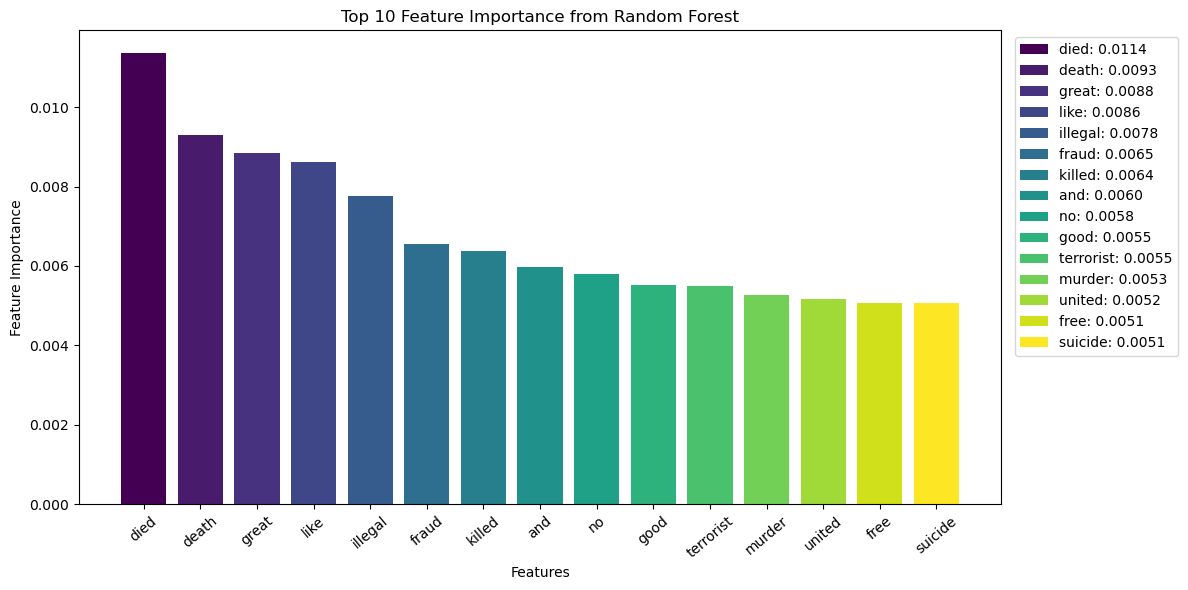

In [ ]:
# Get feature importances from the trained Random Forest model
importances = RFmodel.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 10 important features
top_features_indices = indices[:15]
top_features = X_train.columns[top_features_indices]

# Define colors for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

# Create the bar plot with different colors
plt.figure(figsize=(12, 6))
bars = plt.bar(top_features, importances[top_features_indices], color=colors)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 10 Feature Importance from Random Forest')
plt.xticks(rotation=40)

# Customize the color legend
legend_labels = [f'{feature}: {importance:.4f}' for feature, importance in zip(top_features, importances[top_features_indices])]
plt.legend(bars, legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()

# Show the plot
plt.show()

Further Work: We will use the excluded features from our dataset for better modelling

In [46]:
# Creating dataframe for further works

df1 = tweets.drop(['clean_tweet','tweet','sentiment'],axis=1)
concatenated_df = pd.concat([df1, raw_data],axis=1)

In [52]:
#dropping null values after concating because we have romved some of the data above while removing some noise from our data and the tweets were duplicated

concatenated_df = concatenated_df.dropna()

In [55]:
#This is our final dataset that we will be considering for further work

concatenated_df

,majority_target,followers_count,favourites,friends_count,statuses_count,mentions,replies,cred,tweet,sentiment
0,True,4262.0,10.0,3619.0,16423.0,1.0,1.0,0.540794,@RobertFosterMS To be clearI am tired of heari...,2.0
1,True,1393.0,1.0,1621.0,37184.0,3.0,0.0,0.462177,@oregonclematis And you look at what the progr...,2.0
2,True,9.0,0.0,84.0,1184.0,0.0,5.0,0.096774,@balrednirus @Aprapl @GriffinJesdes You forget...,1.0
3,True,4262.0,0.0,3619.0,16423.0,1.0,0.0,0.540794,@meliclem @killroy Forensic Audit Michigan ele...,1.0
4,True,70.0,1.0,166.0,2194.0,1.0,0.0,0.296610,@mukai Thx If we hold a stock amp the market c...,2.0
...,...,...,...,...,...,...,...,...,...,...
117829,False,2045.0,0.0,2760.0,30517.0,2.0,2.0,0.425598,#GOPDebate more words in the IRS code than the...,2.0
117830,False,4.0,0.0,4.0,790.0,1.0,0.0,0.500000,@navycporet @ChrisPerkins As a Texas citizen I...,1.0
117831,False,2.0,0.0,5.0,353.0,1.0,0.0,0.285714,@FarbridgeXBT @Abuala Bro Shooting bottle rock...,0.0
117832,False,10.0,1.0,151.0,79.0,1.0,1.0,0.062112,The government is committing money to a jobs b...,1.0


In [59]:
concatenated_df.to_csv('FinalDataset.csv',index=False)